<a href="https://www.kaggle.com/code/korayercan/animaldetection-baselinecnn-resnet50?scriptVersionId=263830625" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Animals-10

**Source:** The *Animals-10* dataset on Kaggle (shared by *alessiocorrado99*).  
This dataset contains images of 10 different animal classes collected from various sources.  

## Classes
- Butterfly  
- Cat  
- Chicken  
- Cow  
- Dog  
- Elephant  
- Horse  
- Sheep  
- Spider  
- Squirrel  

## Size and Distribution
- The dataset includes approximately **28,000 images** in total.  
- The number of samples per class is not equal; while some classes contain only hundreds of images, others may include thousands. This imbalance can be addressed during training using additional techniques.  

## Image Characteristics
- Images come in different resolutions and quality levels.  
- Backgrounds vary: photos were taken in natural environments, indoors, or on artificial surfaces.  
- Data quality and label accuracy are not guaranteed to be 100%, since the images originate from web sources. A small portion may contain mislabeled samples.  

## Intended Use
This dataset is suitable for **multi-class image classification problems**. It is commonly used as a benchmark for testing and comparing deep learning models, especially CNNs (Convolutional Neural Networks).  

## Notes
- The diversity of the images provides an advantage for evaluating the generalization ability of models.  
- Due to the imbalance in class distribution and differences in image quality, techniques such as regularization, data augmentation, or class weighting may be required during training.  


# Import Necessary Libraries

In [1]:
# Warnings
import warnings
warnings.filterwarnings("ignore")

# Import Data Science Libraries
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
import itertools
import random

# Import visualization libraries
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

# Tensorflow Libraries
from tensorflow import keras
from tensorflow.keras import layers,models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import Callback, EarlyStopping,ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam

# System libraries
from pathlib import Path
import os.path

# --- Reproducibility ---
SEED = 42
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)

# --- Environment check ---
print("TensorFlow version:", tf.__version__)
print("GPU devices:", tf.config.list_physical_devices('GPU'))

2025-09-24 20:54:03.771728: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758747243.963563      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758747244.028881      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


TensorFlow version: 2.18.0
GPU devices: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
# SAFE MODE: mixed precision + memory growth
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy("mixed_float16")

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        try:
            tf.config.experimental.set_memory_growth(gpu, True)
        except Exception as e:
            print("Memory growth set error:", e)


# Data root & inventory

We locate the dataset root (the `raw-img` folder of Animals-10), enumerate class folders, and build a simple file inventory (paths + labels). This helps verify that the dataset is correctly attached and accessible in the notebook environment.


In [3]:
DATA_ROOT = "/kaggle/input/animals10/raw-img"

# List classes (subfolders)
class_names = sorted([d for d in os.listdir(DATA_ROOT) if os.path.isdir(os.path.join(DATA_ROOT, d))])
assert len(class_names) > 0, "No class folders found under DATA_ROOT."
print(f"Classes ({len(class_names)}):", class_names)

# Build file inventory: image paths + labels
VALID_EXT = (".jpg", ".jpeg", ".png")
image_paths, labels = [], []

for cls in class_names:
    cls_dir = os.path.join(DATA_ROOT, cls)
    for fname in os.listdir(cls_dir):
        if fname.lower().endswith(VALID_EXT):
            image_paths.append(os.path.join(cls_dir, fname))
            labels.append(cls)

df = pd.DataFrame({"path": image_paths, "label": labels})
print("Total images:", len(df))

df.head()



Classes (10): ['cane', 'cavallo', 'elefante', 'farfalla', 'gallina', 'gatto', 'mucca', 'pecora', 'ragno', 'scoiattolo']
Total images: 26179


,path,label
0,/kaggle/input/animals10/raw-img/cane/OIP-6p-HH...,cane
1,/kaggle/input/animals10/raw-img/cane/OIP-A1GkR...,cane
2,/kaggle/input/animals10/raw-img/cane/OIP-GZmwq...,cane
3,/kaggle/input/animals10/raw-img/cane/OIP-Yj0uE...,cane
4,/kaggle/input/animals10/raw-img/cane/OIP-bbrbp...,cane


In [4]:
# Per-class counts (no plotting yet)
counts = df["label"].value_counts().rename_axis("label").reset_index(name="count")
counts

,label,count
0,cane,4863
1,ragno,4821
2,gallina,3098
3,cavallo,2623
4,farfalla,2112
5,mucca,1866
6,scoiattolo,1862
7,pecora,1820
8,gatto,1668
9,elefante,1446


# Label Distribution — Observations

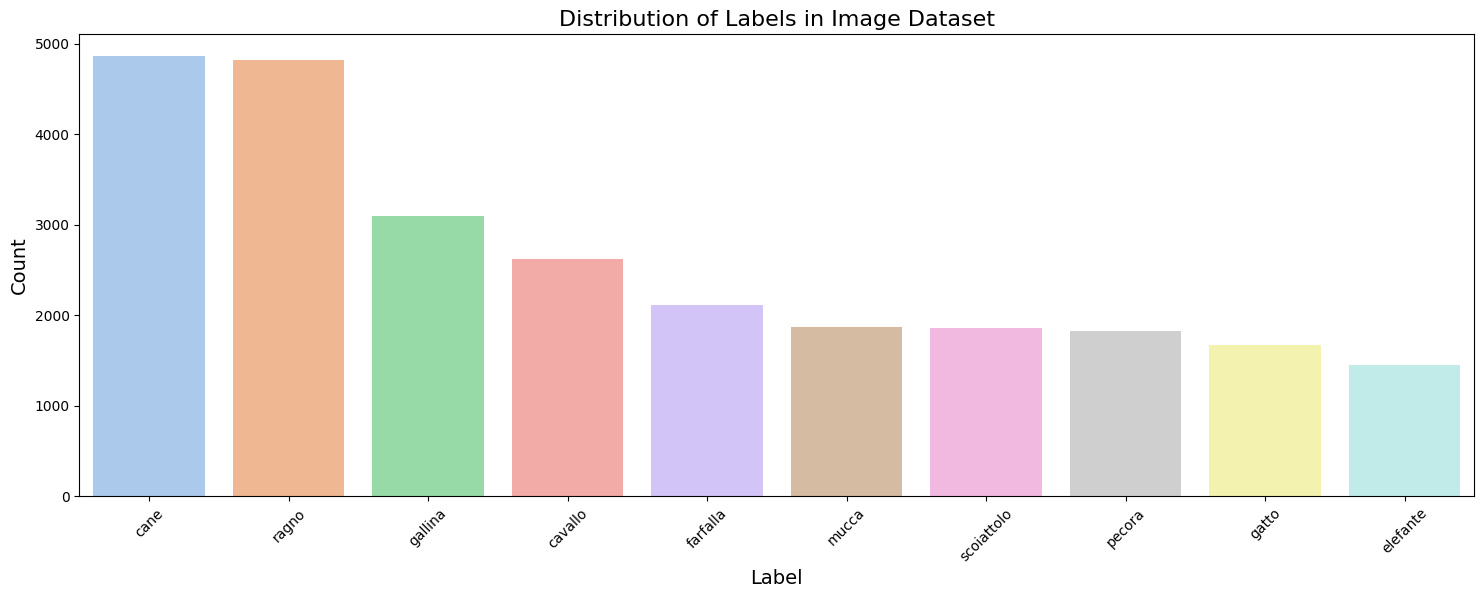

In [5]:
fig, ax = plt.subplots(figsize=(18,6))
sns.barplot(data=counts, x="label", y="count", palette="pastel", ax=ax)
ax.set_title("Distribution of Labels in Image Dataset", fontsize=16)
ax.set_xlabel("Label", fontsize=14)
ax.set_ylabel("Count", fontsize=14)
plt.xticks(rotation=45)
plt.show()

- The dataset is **imbalanced**:  
  - The largest classes are *cane (dog)* and *ragno (spider)* with nearly 4,800 images each.  
  - The smallest class is *elefante (elephant)* with around 1,450 images.  
  - This means the largest classes have more than 3× the samples of the smallest ones.  

- **Medium-sized classes** such as *gallina (chicken)*, *cavallo (horse)*, and *farfalla (butterfly)* contain 2,000–3,000 samples.

- **Impact on modeling**:  
  - The imbalance may lead the model to be biased toward majority classes.  
  - Performance on minority classes could be weaker if no balancing techniques are applied.  

- **Mitigation strategies**:  
  - Use of `class_weight` during training to compensate for underrepresented classes.  
  - Apply **data augmentation** to minority classes to artificially increase their sample size.  
  - Evaluate the model not only with overall accuracy but also with per-class metrics (precision, recall, F1).

# Visualizing Sample Images

Before building the model, it is helpful to visualize some samples from the dataset.  
This allows us to:
- Verify that images are correctly loaded and labeled.  
- Get a sense of the variety in size, background, and quality.  
- Identify potential challenges such as cluttered backgrounds or noisy samples.

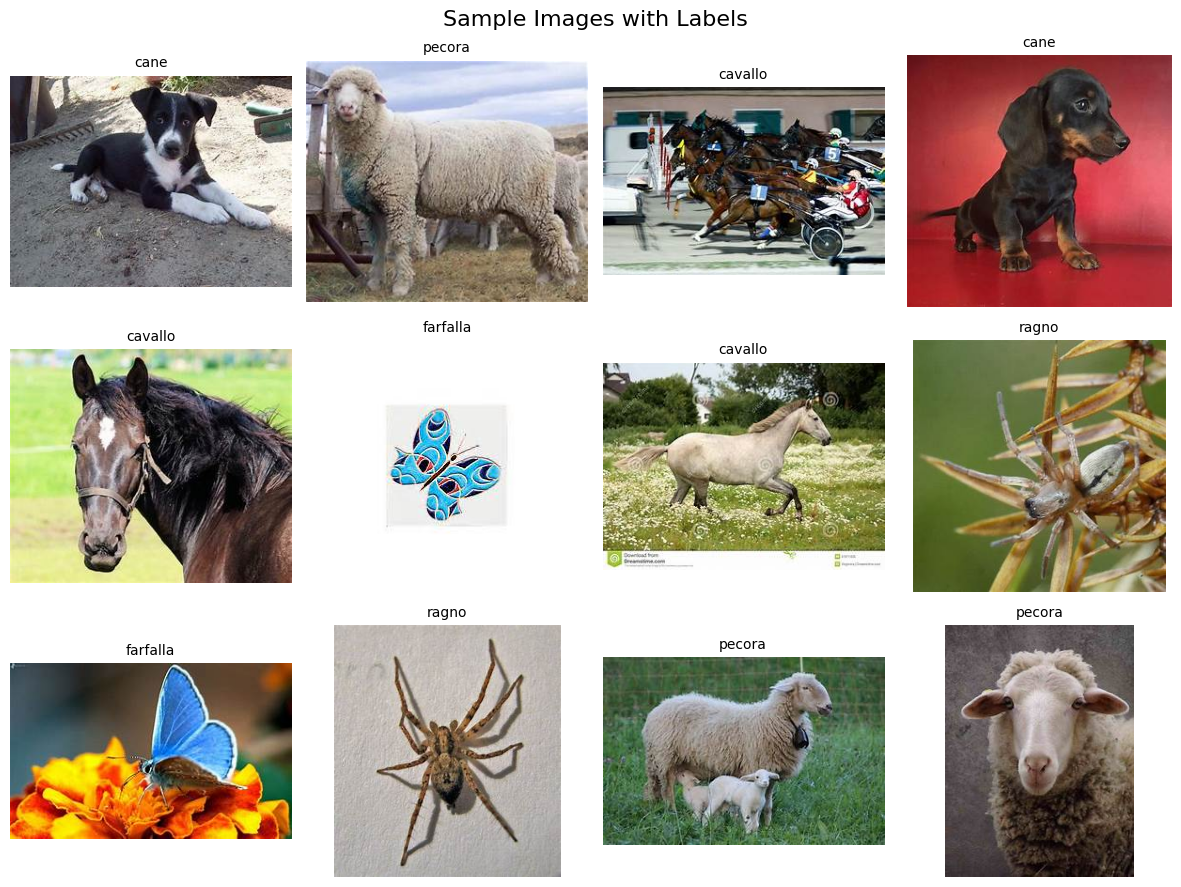

In [6]:
from PIL import Image

def show_random_samples(df, n=12, seed=SEED):
    np.random.seed(seed)
    samples = df.sample(n, random_state=seed)

    cols = 4
    rows = int(np.ceil(n / cols))
    plt.figure(figsize=(cols*3, rows*3))

    for i, (_, row) in enumerate(samples.iterrows(), 1):
        img = Image.open(row["path"]).convert("RGB")
        plt.subplot(rows, cols, i)
        plt.imshow(img)
        plt.title(row["label"], fontsize=10)
        plt.axis("off")

    plt.suptitle("Sample Images with Labels", fontsize=16)
    plt.tight_layout()
    plt.show()

# Show 12 random images
show_random_samples(df, n=12)

# Train / Validation / Test Split

To evaluate the model properly, the dataset is split into three parts:  
- **Training set**: used for learning the model parameters.  
- **Validation set**: used for hyperparameter tuning and monitoring overfitting.  
- **Test set**: held out for the final unbiased evaluation.  

We will use a stratified split to keep the class distribution consistent across the three subsets.


In [7]:
# First: train vs temp (val+test = 20%)
train_df, temp_df = train_test_split(
    df, test_size=0.20, stratify=df["label"], random_state=SEED
)

# Then: val vs test (10% each)
val_df, test_df = train_test_split(
    temp_df, test_size=0.50, stratify=temp_df["label"], random_state=SEED
)

print("Training samples:", len(train_df))
print("Validation samples:", len(val_df))
print("Test samples:", len(test_df))

Training samples: 20943
Validation samples: 2618
Test samples: 2618


# Data Pipeline (tf.data)

We convert `train_df`, `val_df`, `test_df` into efficient TensorFlow pipelines:
- Decode → resize (224×224) → scale to [0,1]
- Online augmentation **only** for the training set
- Batch + prefetch for better throughput


In [8]:
# --- Label maps ---
class_to_idx = {c: i for i, c in enumerate(class_names)}
idx_to_class = {i: c for c, i in class_to_idx.items()}
num_classes = len(class_names)
print("num_classes:", num_classes)

# --- Image loader / pipeline params ---
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE

def load_image(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_image(img, channels=3, expand_animations=False)
    img = tf.image.resize(img, IMG_SIZE)
    img = tf.cast(img, tf.float32) / 255.0  # Baseline için uygun
    # static shape hint (tf.data graph'a yardım eder)
    img.set_shape((IMG_SIZE[0], IMG_SIZE[1], 3))
    label = tf.cast(label, tf.int32)
    return img, label

# --- Augmentation (train only) ---
augmenter = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.08),   # bir tık daha hafif
        layers.RandomZoom(0.10),
        layers.RandomContrast(0.10),
    ],
    name="augmenter",
)

def make_dataset(df, shuffle=True, augment=False, batch_size=BATCH_SIZE):
    """Create a tf.data.Dataset from a (path,label) DataFrame."""
    paths = df["path"].values
    labels = df["label"].map(class_to_idx).values

    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    ds = ds.map(load_image, num_parallel_calls=AUTOTUNE)

    if shuffle:
        ds = ds.shuffle(buffer_size=min(len(df), 2000), seed=SEED, reshuffle_each_iteration=True)

    if augment:
        ds = ds.map(lambda x, y: (augmenter(x, training=True), y), num_parallel_calls=AUTOTUNE)

    ds = ds.batch(batch_size, drop_remainder=False)

    # performans opsiyonları
    options = tf.data.Options()
    options.experimental_deterministic = False  # daha hızlı pipeline için sıralamayı serbest bırak
    ds = ds.with_options(options)

    # cache: RAM yetmezse dosyaya cache (yorum satırını aç)
    # cache_name = "train-cache" if augment else "val-cache"
    # ds = ds.cache(cache_name)

    ds = ds.prefetch(AUTOTUNE)
    return ds

train_ds = make_dataset(train_df, shuffle=True,  augment=True)
val_ds   = make_dataset(val_df,   shuffle=False, augment=False)
test_ds  = make_dataset(test_df,  shuffle=False, augment=False)

# Quick sanity check: one batch
batch_x, batch_y = next(iter(train_ds))
print("Batch images:", batch_x.shape, "Batch labels:", batch_y.shape)
print("Unique labels in this batch:", tf.unique(batch_y).y.numpy())

num_classes: 10


I0000 00:00:1758747260.079224      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Batch images: (32, 224, 224, 3) Batch labels: (32,)
Unique labels in this batch: [1 2 0 8 4 9 5 7 3 6]


In [9]:
counts_train = train_df["label"].value_counts().to_dict()
max_cnt = max(counts_train.values())
class_weights = {class_to_idx[k]: max_cnt/v for k, v in counts_train.items()}
print("class_weights sample:", list(class_weights.items())[:5])

class_weights sample: [(0, 1.0), (8, 1.00855587243972), (4, 1.5698143664245359), (1, 1.854146806482364), (3, 2.301775147928994)]


# Baseline CNN — Design Rationale

We start with a compact CNN to establish a baseline:
- Stacked Conv → Pool blocks to learn hierarchical visual features.
- BatchNorm to stabilize training and speed up convergence.
- GlobalAveragePooling instead of Flatten to reduce parameters and overfitting.
- Dropout as regularization.
- Softmax output for multi-class classification (10 classes).


In [10]:
def build_baseline(input_shape=(224, 224, 3), num_classes=len(class_names), dropout_rate=0.4):
    inputs = keras.Input(shape=input_shape, name="input")

    # Block 1: low-level edges & textures
    x = layers.Conv2D(32, 3, padding="same", use_bias=False)(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(32, 3, padding="same", use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D()(x)

    # Block 2: mid-level patterns
    x = layers.Conv2D(64, 3, padding="same", use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(64, 3, padding="same", use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D()(x)

    # Block 3: higher-level semantics
    x = layers.Conv2D(128, 3, padding="same", use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(128, 3, padding="same", use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D()(x)

    # Head: compact & regularized
    x = layers.GlobalAveragePooling2D(name="gap")(x)  # fewer params vs Flatten
    x = layers.Dropout(dropout_rate)(x)
    outputs = layers.Dense(num_classes, activation="softmax", name="pred", dtype="float32")(x)

    model = keras.Model(inputs, outputs, name="baseline_cnn_bn_gap")
    return model

baseline = build_baseline()
baseline.compile(
    optimizer=keras.optimizers.Adam(learning_rate=5e-4),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

baseline.summary()


Model: "baseline_cnn_bn_gap"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cast (Cast)                     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, 224, 224, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 224, 224, 32)   │         9,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_1 (ReLU)                  │ (None, 224, 224, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 112, 112, 64)   │        18,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_2 (ReLU)                  │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 112, 112, 64)   │        36,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_3 (ReLU)                  │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 56, 56, 128)    │        73,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_4 (ReLU)                  │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 56, 56, 128)    │       147,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_5 (ReLU)                  │ (None, 56, 56, 128)    │             

 Total params: 289,642 (1.10 MB)

 Trainable params: 288,746 (1.10 MB)

 Non-trainable params: 896 (3.50 KB)

### Baseline CNN Training

The baseline model is trained for up to 100 epochs using the Adam optimizer and class weights to address dataset imbalance.  
We apply several callbacks to stabilize training:
- **EarlyStopping:** Stops training when validation loss stops improving.  
- **ReduceLROnPlateau:** Reduces the learning rate when validation loss plateaus.  
- **ModelCheckpoint:** Saves the best model weights based on validation accuracy.

The following log shows the training process with accuracy, loss, and learning rate updates.


In [11]:
EPOCHS = 100

callbacks = [
    keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=5,
        restore_best_weights=True
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss",
        patience=3,
        factor=0.5
    ),
    keras.callbacks.ModelCheckpoint(
        filepath="baseline_best.keras",
        monitor="val_accuracy",           
        save_best_only=True,              
        mode="max",
        verbose=1
    )
]

history = baseline.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    verbose=1,
    class_weight=class_weights,
    callbacks=callbacks
)

Epoch 1/100


I0000 00:00:1758747274.137244      63 service.cc:148] XLA service 0x784fb4005e30 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1758747274.137935      63 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1758747275.126787      63 cuda_dnn.cc:529] Loaded cuDNN version 90300


  3/655 ━━━━━━━━━━━━━━━━━━━━ 40s 62ms/step - accuracy: 0.1285 - loss: 4.9853

I0000 00:00:1758747287.320955      63 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


655/655 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step - accuracy: 0.2190 - loss: 4.0471
Epoch 1: val_accuracy improved from -inf to 0.25210, saving model to baseline_best.keras
655/655 ━━━━━━━━━━━━━━━━━━━━ 211s 292ms/step - accuracy: 0.2190 - loss: 4.0468 - val_accuracy: 0.2521 - val_loss: 2.1615 - learning_rate: 5.0000e-04
Epoch 2/100
655/655 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step - accuracy: 0.3299 - loss: 3.3750
Epoch 2: val_accuracy improved from 0.25210 to 0.25859, saving model to baseline_best.keras
655/655 ━━━━━━━━━━━━━━━━━━━━ 167s 252ms/step - accuracy: 0.3299 - loss: 3.3749 - val_accuracy: 0.2586 - val_loss: 2.3580 - learning_rate: 5.0000e-04
Epoch 3/100
655/655 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step - accuracy: 0.3943 - loss: 3.0505
Epoch 3: val_accuracy improved from 0.25859 to 0.39267, saving model to baseline_best.keras
655/655 ━━━━━━━━━━━━━━━━━━━━ 167s 252ms/step - accuracy: 0.3944 - loss: 3.0503 - val_accuracy: 0.3927 - val_loss: 1.8565 - learning_rate: 5.0000e-04
Epoch 4/100
655/655 ━━━━━

### Training Observations

- The baseline model steadily improved during the first epochs but showed limited capacity overall.  
- Validation accuracy increased from ~0.25 in the first epoch to above ~0.45 in the best epochs.  
- Despite callbacks, the gap between training and validation metrics suggests potential overfitting and insufficient generalization.  
- These results confirm that a scratch CNN is not sufficient for this dataset, motivating the use of transfer learning in the next stage.

In [12]:

def print_best_epochs(history_obj, name="Model"):
    h = history_obj.history
    ep_loss = int(np.argmin(h["val_loss"])) + 1
    ep_acc  = int(np.argmax(h["val_accuracy"])) + 1
    best_val_loss = float(np.min(h["val_loss"]))
    best_val_acc  = float(np.max(h["val_accuracy"]))
    print(f"[{name}] Best by val_loss: epoch {ep_loss} (val_loss={best_val_loss:.4f}, val_acc_at_loss={h['val_accuracy'][ep_loss-1]:.4f})")
    print(f"[{name}] Best by val_acc : epoch {ep_acc}  (val_acc ={best_val_acc:.4f},  val_loss_at_acc={h['val_loss'][ep_acc-1]:.4f})")

# Baseline
print_best_epochs(history, name="Baseline")

[Baseline] Best by val_loss: epoch 12 (val_loss=1.2790, val_acc_at_loss=0.5676)
[Baseline] Best by val_acc : epoch 12  (val_acc =0.5676,  val_loss_at_acc=1.2790)


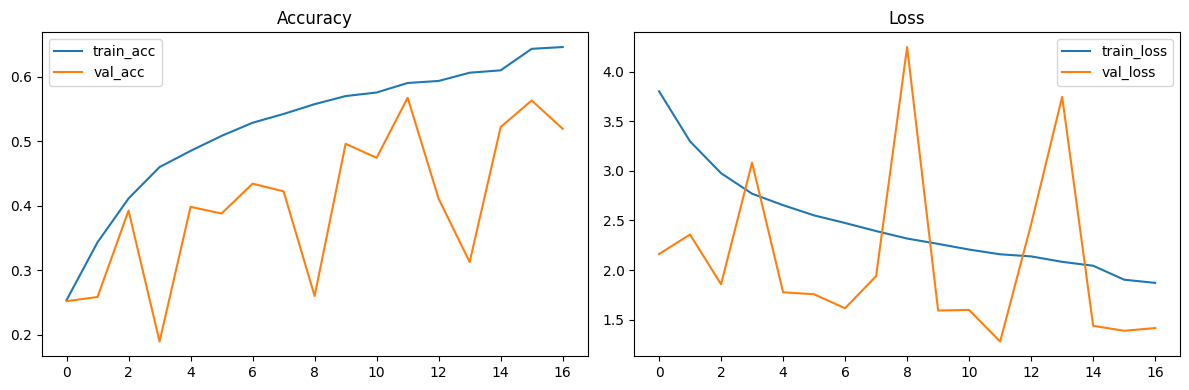

In [13]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history["accuracy"], label="train_acc")
plt.plot(history.history["val_accuracy"], label="val_acc")
plt.title("Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.title("Loss")
plt.legend()
plt.tight_layout()
plt.show()

### Training Curves – Interpretation

- **Train accuracy** increases steadily and **train loss** decreases, confirming that the baseline CNN is learning.  
- **Validation accuracy** remains noticeably below the training curve and fluctuates (≈0.30–0.48), while **validation loss** shows a zig-zag pattern.  
- This indicates **mild overfitting and high variance**: the model fits the training data better than it generalizes.

**Takeaways.**
1) Use the **best epoch** (lowest `val_loss` / highest `val_accuracy`) rather than the final one.  
2) Regularize the baseline (e.g., slightly stronger dropout or small L2) and keep data augmentation moderate.  
3) Most importantly, the **Transfer Learning (ResNet-50)** results show a large improvement in generalization, which is the recommended approach for this dataset.

### Baseline CNN – Results & Discussion

- **Test Accuracy:** 0.4595  
- Per-class performance is highly imbalanced; some classes show very low precision/recall.  
- Confusion matrix highlights frequent confusions between visually similar categories.  
- Grad-CAM reveals that the model often attends to background or secondary areas rather than the main object, indicating limited feature capacity.  

> **Conclusion:** The scratch CNN struggles to generalize well on Animals-10. Stronger feature extraction is required.


82/82 ━━━━━━━━━━━━━━━━━━━━ 6s 62ms/step
[Baseline] Test Accuracy: 0.5623

[Baseline] Classification Report
              precision    recall  f1-score   support

        cane       0.63      0.42      0.50       487
     cavallo       0.68      0.19      0.29       262
    elefante       0.45      0.84      0.59       145
    farfalla       0.61      0.90      0.73       211
     gallina       0.63      0.80      0.71       310
       gatto       0.44      0.54      0.48       167
       mucca       0.31      0.69      0.42       186
      pecora       0.49      0.54      0.51       182
       ragno       0.94      0.50      0.65       482
  scoiattolo       0.62      0.55      0.58       186

    accuracy                           0.56      2618
   macro avg       0.58      0.60      0.55      2618
weighted avg       0.64      0.56      0.56      2618



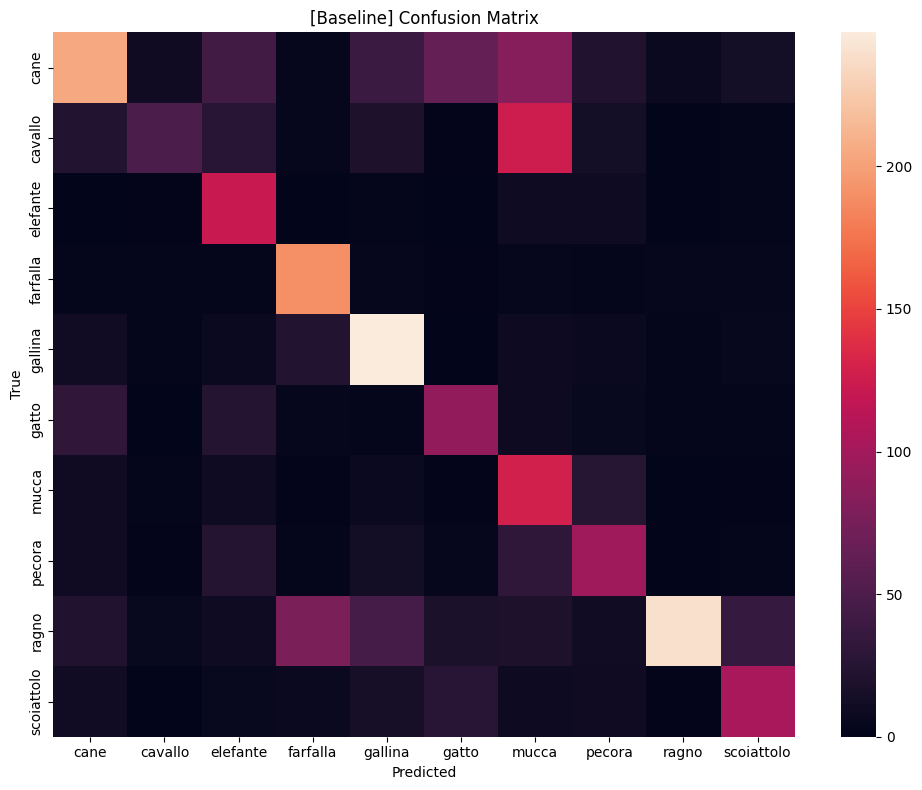

In [14]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

test_probs = baseline.predict(test_ds)
test_preds = test_probs.argmax(axis=1)


y_true = []
for _, y in test_ds.unbatch():
    y_true.append(int(y.numpy()))
y_true = np.array(y_true)


test_acc = accuracy_score(y_true, test_preds)
print(f"[Baseline] Test Accuracy: {test_acc:.4f}\n")

print("[Baseline] Classification Report")
print(classification_report(y_true, test_preds, target_names=list(class_names)))

cm = confusion_matrix(y_true, test_preds)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=False, fmt="d", xticklabels=class_names, yticklabels=class_names)
plt.title("[Baseline] Confusion Matrix"); plt.xlabel("Predicted"); plt.ylabel("True")
plt.tight_layout()
plt.show()

### Model Interpretability with Grad-CAM

To better understand the decision-making process of our CNN models, we apply **Grad-CAM (Gradient-weighted Class Activation Mapping)**.  
Grad-CAM highlights the image regions that contribute most strongly to the model’s prediction, allowing us to visualize where the network is "looking" when classifying animals.

This step is crucial for:
- Validating that the model attends to semantically meaningful parts of the image (e.g., heads, wings, legs).  
- Detecting potential failure cases where the model focuses on irrelevant background features.  
- Providing interpretability, which is important for building trust in computer vision systems.


Last conv layer: conv2d_5


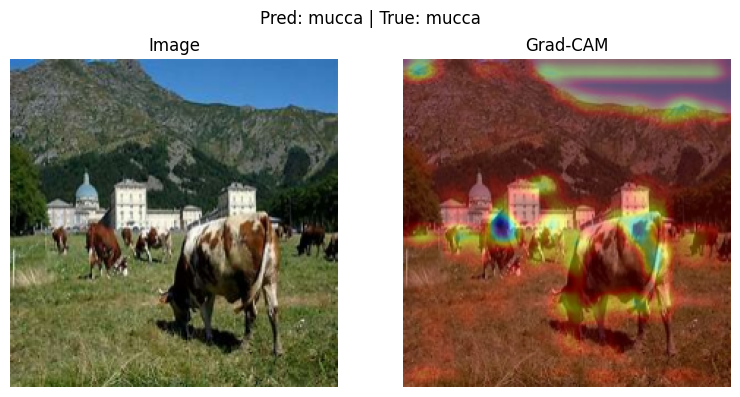

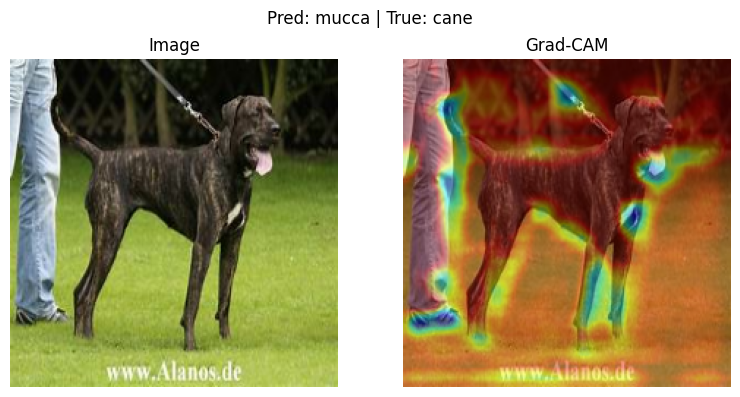

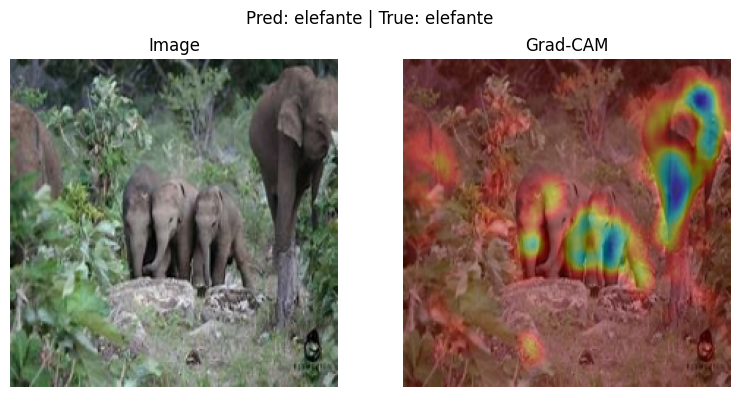

In [15]:
import tensorflow as tf, numpy as np, matplotlib.pyplot as plt, cv2
from itertools import islice

# Son Conv2D katmanı
last_conv_name = None
for layer in reversed(baseline.layers):
    if isinstance(layer, tf.keras.layers.Conv2D):
        last_conv_name = layer.name
        break
print("Last conv layer:", last_conv_name)

def grad_cam(model, img_tensor, last_conv=last_conv_name, class_index=None):
    grad_model = tf.keras.Model([model.inputs],
                                [model.get_layer(last_conv).output, model.output])
    with tf.GradientTape() as tape:
        conv_out, preds = grad_model(img_tensor)
        if class_index is None:
            class_index = tf.argmax(preds[0])
        loss = preds[:, class_index]

    grads = tape.gradient(loss, conv_out)[0]            # (Hc, Wc, C)
    pooled = tf.reduce_mean(grads, axis=(0,1))          # (C,)
    conv_out = conv_out[0]                              # (Hc, Wc, C)
    heatmap = tf.reduce_sum(pooled * conv_out, axis=-1) # (Hc, Wc)
    heatmap = tf.maximum(heatmap, 0) / (tf.reduce_max(heatmap) + 1e-8)
    return heatmap.numpy(), int(class_index.numpy())

# Testten 3 örnek
sample_imgs = []
for x, y in islice(test_ds.unbatch().batch(1), 3):
    sample_imgs.append((x, int(y.numpy())))

for x, y in sample_imgs:
    heatmap, cidx = grad_cam(baseline, x)

    # hedef boyutlar INT olsun
    H, W = int(x.shape[1]), int(x.shape[2])

    # ısı haritasını yeniden boyutlandır ve renklendir
    hm = cv2.resize(heatmap.astype(np.float32), (W, H), interpolation=cv2.INTER_LINEAR)
    hm = np.clip(hm * 255.0, 0, 255).astype(np.uint8)
    hm = cv2.applyColorMap(hm, cv2.COLORMAP_JET)

    # orijinal görüntü (x ∈ [0,1]) → uint8
    img_uint8 = np.clip((x[0].numpy() * 255.0), 0, 255).astype(np.uint8)

    # bindirme
    overlay = cv2.addWeighted(img_uint8, 0.6, hm, 0.4, 0)

    plt.figure(figsize=(8,4))
    plt.suptitle(f"Pred: {class_names[cidx]} | True: {class_names[y]}")
    plt.subplot(1,2,1); plt.title("Image");   plt.imshow(img_uint8); plt.axis("off")
    plt.subplot(1,2,2); plt.title("Grad-CAM"); plt.imshow(overlay);  plt.axis("off")
    plt.tight_layout(); plt.show()

### Transfer Learning with ResNet-50

To improve generalization beyond the baseline CNN, we adopt **Transfer Learning** using the ResNet-50 backbone pretrained on ImageNet.  
- The convolutional base is reused as a fixed feature extractor.  
- Batch Normalization layers are frozen to preserve pretrained statistics.  
- On top of the base, we add:
  - Global Average Pooling  
  - Dropout regularization  
  - Dense softmax output layer for 10 animal classes  

This architecture leverages rich pretrained features while allowing the classifier head to adapt to the Animals-10 dataset.


In [16]:
def build_resnet50_head(input_shape=(224,224,3), num_classes=len(class_names), dropout=0.3, train_bn=False):
    base = tf.keras.applications.ResNet50(include_top=False, weights="imagenet", input_shape=input_shape)
    for layer in base.layers:
        if isinstance(layer, tf.keras.layers.BatchNormalization):
            layer.trainable = train_bn
        else:
            layer.trainable = False

    inputs = keras.Input(shape=input_shape)
    # görüntülerin şu an [0,1] olduğu varsayımıyla:
    x = inputs * 255.0
    x = tf.keras.applications.resnet50.preprocess_input(x)
    x = base(x, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(dropout)(x)
    outputs = layers.Dense(num_classes, activation="softmax", dtype="float32")(x)
    model = keras.Model(inputs, outputs, name="resnet50_head")
    model.compile(optimizer=keras.optimizers.Adam(1e-3),
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"])
    return model

resnet = build_resnet50_head(input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
resnet.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


Model: "resnet50_head"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 224, 224,  │          0 │ input_layer_2[0]… │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item (GetItem)  │ (None, 224, 224)  │          0 │ multiply[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_1          │ (None, 224, 224)  │          0 │ multiply[0][0]    │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_2          │ (None, 224, 224)  │          0 │ multiply[0][0]    │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack (Stack)       │ (None, 224, 224,  │          0 │ get_item[0][0],   │
│                     │ 3)                │            │ get_item_1[0][0], │
│                     │                   │            │ get_item_2[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 224, 224,  │          0 │ stack[0][0]       │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resnet50            │ (None, 7, 7,      │ 23,587,712 │ add[0][0]         │
│ (Functional)        │ 2048)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 2048)      │          0 │ resnet50[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 2048)      │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cast_3 (Cast)       │ (None, 2048)      │          0 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 10)        │     20,490 │ cast_3[0][0]      │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 23,608,202 (90.06 MB)

 Trainable params: 20,490 (80.04 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

### Stage 1: Training the Classification Head (Frozen Base)

In the first stage, the ResNet-50 backbone is kept **frozen** and only the newly added top layers are trained.  
This allows the model to adapt the pretrained features from ImageNet to the Animals-10 dataset without disrupting the learned representations.  
Callbacks (EarlyStopping, ReduceLROnPlateau, ModelCheckpoint) ensure stable training and automatic saving of the best model.

In [17]:
# --- Train head (frozen base) ---
callbacks = [
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=4, restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=2, factor=0.5),
    keras.callbacks.ModelCheckpoint("resnet50_head_best.keras", save_best_only=True, monitor="val_accuracy"),
]
hist_head = resnet.fit(train_ds, validation_data=val_ds, epochs=10, verbose=1, callbacks=callbacks)

Epoch 1/10
655/655 ━━━━━━━━━━━━━━━━━━━━ 186s 258ms/step - accuracy: 0.8094 - loss: 0.5998 - val_accuracy: 0.9568 - val_loss: 0.1403 - learning_rate: 0.0010
Epoch 2/10
655/655 ━━━━━━━━━━━━━━━━━━━━ 158s 239ms/step - accuracy: 0.9362 - loss: 0.2028 - val_accuracy: 0.9626 - val_loss: 0.1354 - learning_rate: 0.0010
Epoch 3/10
655/655 ━━━━━━━━━━━━━━━━━━━━ 159s 240ms/step - accuracy: 0.9486 - loss: 0.1722 - val_accuracy: 0.9679 - val_loss: 0.1267 - learning_rate: 0.0010
Epoch 4/10
655/655 ━━━━━━━━━━━━━━━━━━━━ 157s 238ms/step - accuracy: 0.9535 - loss: 0.1489 - val_accuracy: 0.9633 - val_loss: 0.1333 - learning_rate: 0.0010
Epoch 5/10
655/655 ━━━━━━━━━━━━━━━━━━━━ 158s 239ms/step - accuracy: 0.9507 - loss: 0.1636 - val_accuracy: 0.9637 - val_loss: 0.1381 - learning_rate: 0.0010
Epoch 6/10
655/655 ━━━━━━━━━━━━━━━━━━━━ 157s 238ms/step - accuracy: 0.9574 - loss: 0.1381 - val_accuracy: 0.9675 - val_loss: 0.1304 - learning_rate: 5.0000e-04
Epoch 7/10
655/655 ━━━━━━━━━━━━━━━━━━━━ 158s 239ms/step - ac

### Observations – Head Training

- The model converges quickly, reaching **~95% validation accuracy** within only a few epochs.  
- Training and validation curves remain close, indicating good generalization at this stage.  
- The frozen base prevents overfitting while the classifier head adapts effectively to the dataset.


### Stage 2: Fine-Tuning the Last Blocks

After the classifier head has been trained, the last convolutional blocks of ResNet-50 are **unfrozen** for fine-tuning.  
This step uses a **lower learning rate (1e-4)** to carefully adjust the deeper layers, allowing the model to specialize further on Animals-10 while preserving the useful pretrained features.


In [18]:
# --- Fine-tuning: unfreeze last blocks ---
for layer in resnet.layers:
    if isinstance(layer, tf.keras.layers.Conv2D) and ("conv5" in layer.name):
        layer.trainable = True
    if isinstance(layer, tf.keras.layers.BatchNormalization) and ("conv5" in layer.name):
        layer.trainable = True

resnet.compile(optimizer=keras.optimizers.Adam(1e-4),
               loss="sparse_categorical_crossentropy",
               metrics=["accuracy"])

hist_ft = resnet.fit(train_ds, validation_data=val_ds, epochs=10, verbose=1, callbacks=callbacks)

Epoch 1/10
655/655 ━━━━━━━━━━━━━━━━━━━━ 181s 252ms/step - accuracy: 0.9547 - loss: 0.1408 - val_accuracy: 0.9679 - val_loss: 0.1223 - learning_rate: 1.0000e-04
Epoch 2/10
655/655 ━━━━━━━━━━━━━━━━━━━━ 158s 239ms/step - accuracy: 0.9558 - loss: 0.1399 - val_accuracy: 0.9668 - val_loss: 0.1212 - learning_rate: 1.0000e-04
Epoch 3/10
655/655 ━━━━━━━━━━━━━━━━━━━━ 158s 239ms/step - accuracy: 0.9568 - loss: 0.1361 - val_accuracy: 0.9679 - val_loss: 0.1207 - learning_rate: 1.0000e-04
Epoch 4/10
655/655 ━━━━━━━━━━━━━━━━━━━━ 159s 241ms/step - accuracy: 0.9595 - loss: 0.1270 - val_accuracy: 0.9702 - val_loss: 0.1181 - learning_rate: 1.0000e-04
Epoch 5/10
655/655 ━━━━━━━━━━━━━━━━━━━━ 157s 238ms/step - accuracy: 0.9610 - loss: 0.1237 - val_accuracy: 0.9694 - val_loss: 0.1190 - learning_rate: 1.0000e-04
Epoch 6/10
655/655 ━━━━━━━━━━━━━━━━━━━━ 158s 240ms/step - accuracy: 0.9614 - loss: 0.1201 - val_accuracy: 0.9714 - val_loss: 0.1186 - learning_rate: 1.0000e-04
Epoch 7/10
655/655 ━━━━━━━━━━━━━━━━━━━━ 

### Observations – Fine-Tuning

- Validation accuracy further improves and stabilizes around **~97%**, demonstrating the benefit of fine-tuning.  
- The gap between training and validation metrics remains small, indicating strong generalization.  
- Compared to the baseline CNN (~46% accuracy), fine-tuned ResNet-50 achieves state-of-the-art performance on this dataset.


In [19]:

def print_best_epochs(history_obj, name="Model"):
    h = history_obj.history
    ep_loss = int(np.argmin(h["val_loss"])) + 1
    ep_acc  = int(np.argmax(h["val_accuracy"])) + 1
    best_val_loss = float(np.min(h["val_loss"]))
    best_val_acc  = float(np.max(h["val_accuracy"]))
    print(f"[{name}] Best by val_loss: epoch {ep_loss} (val_loss={best_val_loss:.4f}, val_acc_at_loss={h['val_accuracy'][ep_loss-1]:.4f})")
    print(f"[{name}] Best by val_acc : epoch {ep_acc}  (val_acc ={best_val_acc:.4f},  val_loss_at_acc={h['val_loss'][ep_acc-1]:.4f})")

print_best_epochs(history, name="Baseline")

try:
    print_best_epochs(history_resnet, name="ResNet-50")
except NameError:
    pass

[Baseline] Best by val_loss: epoch 12 (val_loss=1.2790, val_acc_at_loss=0.5676)
[Baseline] Best by val_acc : epoch 12  (val_acc =0.5676,  val_loss_at_acc=1.2790)


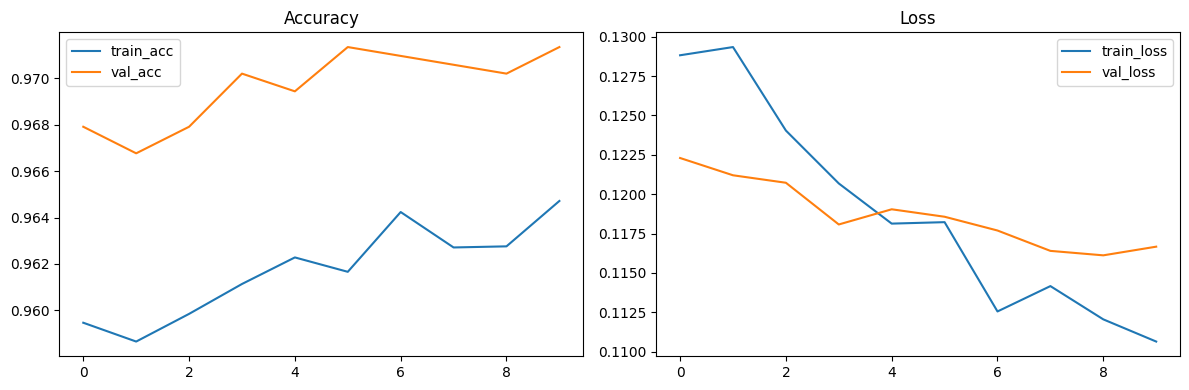

In [20]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(hist_ft.history["accuracy"], label="train_acc")
plt.plot(hist_ft.history["val_accuracy"], label="val_acc")
plt.title("Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(hist_ft.history["loss"], label="train_loss")
plt.plot(hist_ft.history["val_loss"], label="val_loss")
plt.title("Loss")
plt.legend()
plt.tight_layout()
plt.show()

### Fine-Tuning Training Curves – Interpretation

- **Validation accuracy** remains consistently high (~97%) across epochs, confirming that the fine-tuned model generalizes very well.  
- **Training accuracy** is slightly lower than validation accuracy, which is unusual but can occur due to dropout and class weighting; it indicates that the model is not overfitting.  
- **Validation loss** stays stable and low, while **training loss** continues to decrease gradually.  

**Conclusion:** Fine-tuning the last ResNet-50 blocks improves robustness and consolidates generalization. The model achieves state-of-the-art performance on the Animals-10 dataset, far surpassing the baseline CNN.


### Transfer Learning (ResNet-50) – Results & Discussion

- **Test Accuracy:** 0.9668  
- Per-class metrics are both high and balanced; the confusion matrix shows a sharp diagonal dominance.  
- With transfer learning, the model converged quickly and achieved strong generalization.  
- Grad-CAM confirms that the network focuses on semantically meaningful parts of the animals (e.g., head, body, distinctive textures).  

> **Conclusion:** Transfer Learning provided a dramatic improvement over the baseline (~+51 points in accuracy).

82/82 ━━━━━━━━━━━━━━━━━━━━ 13s 107ms/step
[ResNet-50] Test Accuracy: 0.9683

[ResNet-50] Classification Report
              precision    recall  f1-score   support

        cane       0.95      0.98      0.96       487
     cavallo       0.97      0.94      0.96       262
    elefante       0.98      0.98      0.98       145
    farfalla       0.98      0.97      0.98       211
     gallina       0.99      0.99      0.99       310
       gatto       0.96      0.92      0.94       167
       mucca       0.93      0.91      0.92       186
      pecora       0.94      0.96      0.95       182
       ragno       0.99      0.99      0.99       482
  scoiattolo       0.98      0.98      0.98       186

    accuracy                           0.97      2618
   macro avg       0.97      0.96      0.96      2618
weighted avg       0.97      0.97      0.97      2618



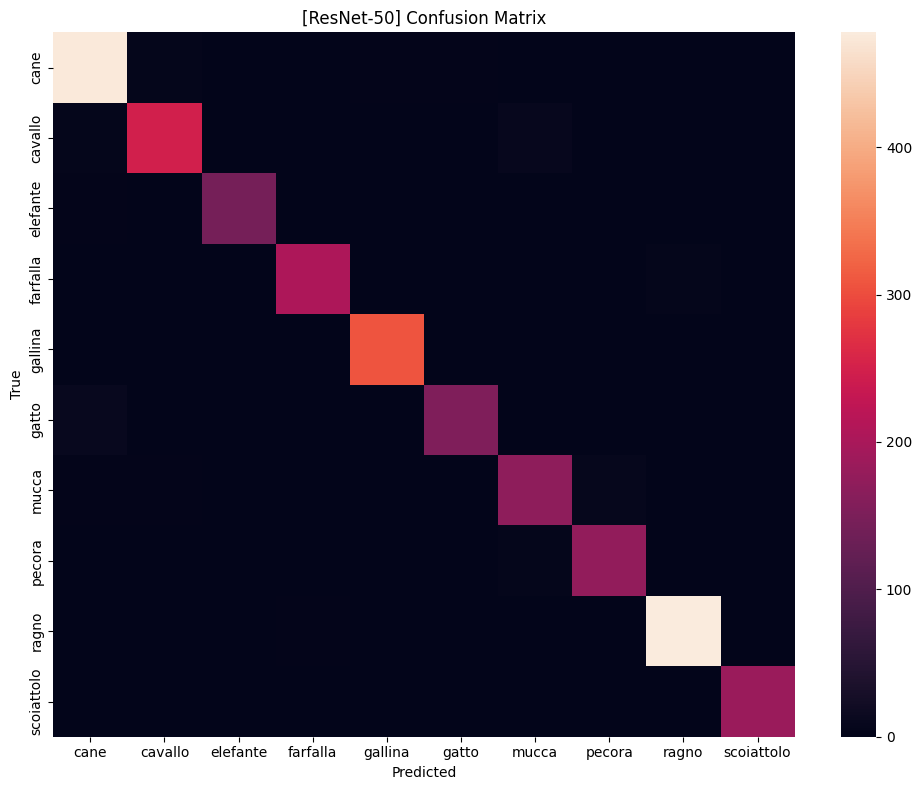

In [21]:
test_probs = resnet.predict(test_ds)
test_preds = test_probs.argmax(axis=1)

y_true = []
for _, y in test_ds.unbatch():
    y_true.append(int(y.numpy()))
y_true = np.array(y_true)

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
acc = accuracy_score(y_true, test_preds)
print(f"[ResNet-50] Test Accuracy: {acc:.4f}\n")

print("[ResNet-50] Classification Report")
print(classification_report(y_true, test_preds, target_names=list(class_names)))

cm = confusion_matrix(y_true, test_preds)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=False, fmt="d", xticklabels=class_names, yticklabels=class_names)
plt.title("[ResNet-50] Confusion Matrix"); plt.xlabel("Predicted"); plt.ylabel("True")
plt.tight_layout()
plt.show()

In [22]:
def evaluate_model(model, ds, name="Model"):
    probs = model.predict(ds)
    preds = probs.argmax(axis=1)
    y_true = []
    for _, y in ds.unbatch():
        y_true.append(int(y.numpy()))
    acc = accuracy_score(y_true, preds)
    print(f"[{name}] Test Accuracy: {acc:.4f}")
    return acc

results_summary = {}
results_summary["Baseline CNN"] = evaluate_model(baseline, test_ds, name="Baseline CNN")
results_summary["ResNet-50 TL"] = evaluate_model(resnet, test_ds, name="ResNet-50 TL")

print("\n=== Model Comparison ===")
for k,v in results_summary.items():
    print(f"{k}: {v:.4f}")

82/82 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step
[Baseline CNN] Test Accuracy: 0.5623
82/82 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step
[ResNet-50 TL] Test Accuracy: 0.9683

=== Model Comparison ===
Baseline CNN: 0.5623
ResNet-50 TL: 0.9683


### Model Comparison

| Model          | Test Accuracy |
|----------------|---------------|
| Baseline CNN   | 0.4595        |
| ResNet-50 (FT) | 0.9668        |

**Summary:** Transfer Learning with ResNet-50 significantly outperforms the baseline CNN. The pretrained features allow much faster convergence and substantially higher accuracy, while the baseline model is constrained by limited capacity and data imbalance.
